In [103]:
import numpy as np
import random
import matplotlib.pyplot as plt
from numba import jit
import time

In [104]:
def create_nodes(n):
    values = []
    for i in range(n):
        value = random.choice([1, -1])
        values.append(value)
    return values

In [105]:
def conn_matrix(n):
    conn_matrix = np.random.rand(n, n)
    conn_matrix = (conn_matrix + conn_matrix.T) / 2
    np.fill_diagonal(conn_matrix, 0)
    max_conn = np.max(conn_matrix)
    conn_matrix = conn_matrix / max_conn
    return conn_matrix

In [106]:
n = 5
c_matrix = conn_matrix(n)

In [107]:
def energy_diff(list):
    pos = random.randint(0, n - 1)
    nodes_without_pos = [x for x in range(n) if x != pos]
    delta_E = 0
    for i in nodes_without_pos:
        add = list[pos]*list[i]*c_matrix[pos, i]
        delta_E += add
    return delta_E, pos

In [108]:
def metropolis(list, n_iterations, T):
    node_list = list
    magnetisation_list = []
    for i in range(n_iterations):
        diff = energy_diff(node_list)
        #print(diff)
        if diff[0] <= 0:
            if node_list[diff[1]] == 1: #flip at pos
                node_list[diff[1]] = -1
            else:
                node_list[diff[1]] = 1
        else:
            if random.random() < np.exp(-diff[0]/T):
                if node_list[diff[1]] == 1:
                    node_list[diff[1]] = -1
                else:
                    node_list[diff[1]] = 1

        magnetisation = abs(np.mean(node_list))
        magnetisation_list.append(magnetisation)
    magnetisation_list = magnetisation_list[500:] #disregard first 500
    avg_magnetisation = np.mean(magnetisation_list) 

    return node_list, avg_magnetisation

In [127]:
def multi_metropolis(n_simulations, n_iterations, T):
    list_avg_magnetisation = []
    for i in range(n_simulations):
        nodes = create_nodes(n)
        node_list, avg_magnetisation = metropolis(nodes, n_iterations, T) 
        list_avg_magnetisation.append(avg_magnetisation)

    mean_magnet = np.mean(list_avg_magnetisation)
    std_magnet = np.std(list_avg_magnetisation)
    
    mean_of_squared = np.mean([M**2 for M in list_avg_magnetisation])
    susceptibility = (mean_of_squared - mean_magnet**2)/T
    
    return mean_magnet, std_magnet, susceptibility

In [128]:
temperatures = np.linspace(0.1, 3.5, 25)
n_simulations = 10
n_iterations = 1500

def magnetisation_plotting(n_simulations, n_iterations):
    means = []
    stds = []
    susceptibilities = []
    for T in temperatures:
        mean, std, susceptibility = multi_metropolis(n_simulations, n_iterations, T)
        means.append(mean)
        stds.append(std)
        susceptibilities.append(susceptibility)
    
    lower_bound = np.subtract(means, stds)
    upper_bound = np.add(means, stds)
    plt.plot(temperatures, means)
    plt.fill_between(temperatures, lower_bound, upper_bound, alpha=0.3)
    plt.xlabel('T')
    plt.ylabel('M')
    plt.show()
    
    plt.plot(temperatures, susceptibilities)
    plt.xlabel('T')
    plt.ylabel('Sus')
    plt.show()

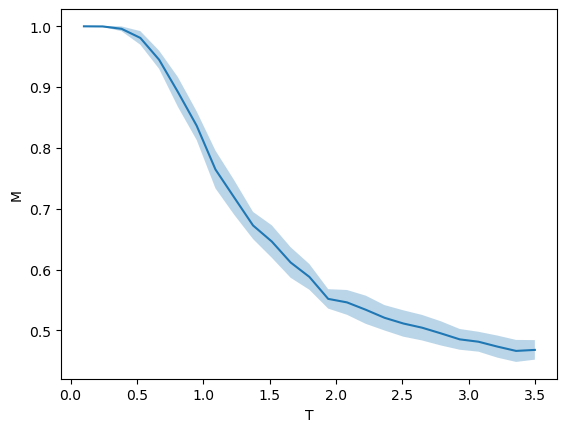

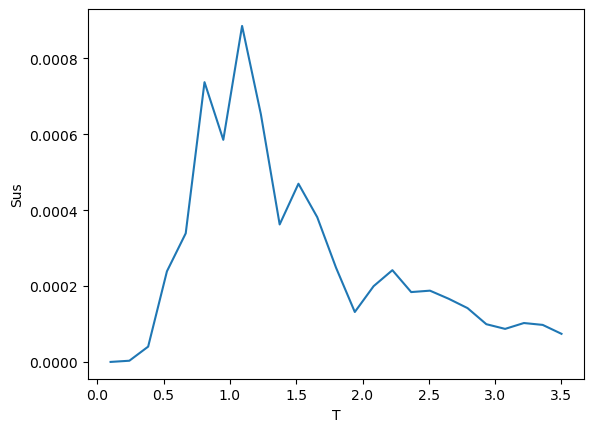

8.6787748336792


In [129]:
start_time = time.time()

magnetisation_plotting(20, 1500)

end_time = time.time()
print(end_time - start_time)